In [3]:
### Obtain the libraries;

import pandas as pd
import numpy as np
import scipy as sp
import os
#from xgboost import XGBClassifier
#import xgboost as xgb
import operator
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.model_selection import LeaveOneOut

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot



In [5]:
os.getcwd()

'D:\\[Learning]\\Kaggle\\AceaWater\\Italy_Aquifer'

In [6]:
os.getcwd()

Aquifer_Luco = pd.read_csv("Aquifer_Luco.csv", sep = ',')
Aquifer_Luco = Aquifer_Luco.iloc[:, 0:]
Aquifer_Luco.head()


,Date,Rainfall_Simignano,Rainfall_Siena_Poggio_al_Vento,Rainfall_Mensano,Rainfall_Montalcinello,Rainfall_Monticiano_la_Pineta,Rainfall_Sovicille,Rainfall_Ponte_Orgia,Rainfall_Scorgiano,Rainfall_Pentolina,...,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Temperature_Siena_Poggio_al_Vento,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Volume_Pozzo_1,Volume_Pozzo_3,Volume_Pozzo_4
0,01/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,5.50,0.80,NaN,NaN,NaN
1,02/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,6.20,3.25,NaN,NaN,NaN
2,03/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.25,0.95,NaN,NaN,NaN
3,04/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.00,4.20,NaN,NaN,NaN
4,05/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.90,6.55,NaN,NaN,NaN


In [7]:
print(list(Aquifer_Luco))

['Date', 'Rainfall_Simignano', 'Rainfall_Siena_Poggio_al_Vento', 'Rainfall_Mensano', 'Rainfall_Montalcinello', 'Rainfall_Monticiano_la_Pineta', 'Rainfall_Sovicille', 'Rainfall_Ponte_Orgia', 'Rainfall_Scorgiano', 'Rainfall_Pentolina', 'Rainfall_Monteroni_Arbia_Biena', 'Depth_to_Groundwater_Podere_Casetta', 'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Temperature_Siena_Poggio_al_Vento', 'Temperature_Mensano', 'Temperature_Pentolina', 'Temperature_Monteroni_Arbia_Biena', 'Volume_Pozzo_1', 'Volume_Pozzo_3', 'Volume_Pozzo_4']


In [9]:
### Obtain from the first non-missing data point

depth_p_c = Aquifer_Luco[Aquifer_Luco.Depth_to_Groundwater_Podere_Casetta.first_valid_index()]

depth_p_c



KeyError: 2973

In [10]:
# Part 1: Start with simple time series forecast;
### Mean Imputation;
Aquifer_Luco['Depth_to_Groundwater_Podere_Casetta'].fillna((Aquifer_Luco['Depth_to_Groundwater_Podere_Casetta'].mean()), inplace=True)


In [11]:
Aquifer_Luco[['Depth_to_Groundwater_Podere_Casetta']]

,Depth_to_Groundwater_Podere_Casetta
0,-7.079229
1,-7.079229
2,-7.079229
3,-7.079229
4,-7.079229
...,...
7482,-7.079229
7483,-7.079229
7484,-7.079229
7485,-7.079229


In [12]:
register_matplotlib_converters()

In [13]:
## Check the sample size;
len(Aquifer_Luco)

7487

In [14]:
# Aquifer_Luco['YearMonth'] = Aquifer_Luco['Date'] + pd.offsets.MonthEnd(-1) + pd.offsets.Day(1)

# Aquifer_Luco['YearMonth'] = Aquifer_Luco['Date'] - pd.to_timedelta(Aquifer_Luco['Date'].dt.day-1, unit='D')

Aquifer_Luco['YearMonth'] = pd.to_datetime(Aquifer_Luco['Date']).apply(lambda x: '{year}{month}'.format(year=x.year, month=x.month))


In [15]:
Aquifer_Luco[['YearMonth']]

,YearMonth
0,20001
1,20002
2,20003
3,20004
4,20005
...,...
7482,20206
7483,20206
7484,20206
7485,20206


In [16]:
Aquifer_Luco['Year_Month'] = pd.to_datetime(Aquifer_Luco['YearMonth'], format='%Y%m')

In [17]:
pd_0 = Aquifer_Luco.groupby('Year_Month', sort=True)["Depth_to_Groundwater_Podere_Casetta"].sum().reset_index(name ='Monthly Depth')

In [18]:
pd_0.head()

,Year_Month,Monthly Depth
0,2000-01-01,-219.456097
1,2000-02-01,-205.297639
2,2000-03-01,-219.456097
3,2000-04-01,-212.376868
4,2000-05-01,-219.456097


SyntaxError: invalid syntax (<ipython-input-29-9c8f78ce8222>, line 1)

In [19]:
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [28]:
y = pd_0['Monthly Depth']

In [36]:
y1 = y - y.shift(1)

In [37]:
y1

0            NaN
1      14.158458
2     -14.158458
3       7.079229
4      -7.079229
         ...    
247     0.000000
248     0.000000
249     0.000000
250     0.000000
251     0.000000
Name: Monthly Depth, Length: 252, dtype: float64

In [62]:
y

0     -219.456097
1     -205.297639
2     -219.456097
3     -212.376868
4     -219.456097
          ...    
247    -42.475374
248    -42.475374
249    -42.475374
250    -42.475374
251    -42.475374
Name: Monthly Depth, Length: 252, dtype: float64

In [64]:
y.shift(1)

0             NaN
1     -219.456097
2     -205.297639
3     -219.456097
4     -212.376868
          ...    
247    -42.475374
248    -42.475374
249    -42.475374
250    -42.475374
251    -42.475374
Name: Monthly Depth, Length: 252, dtype: float64

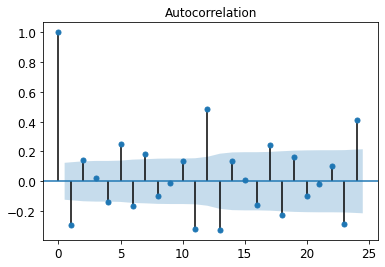

In [40]:
### Draw adf plot

plot_acf(y1[1:-1])
pyplot.show()

### This indicates q = 8; 

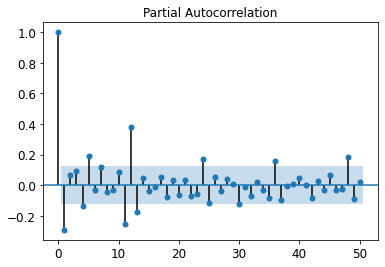

In [42]:
### Draw partial acf plot

plot_pacf(y1[1:-1], lags=50)
pyplot.show()

## This indicates p = 7

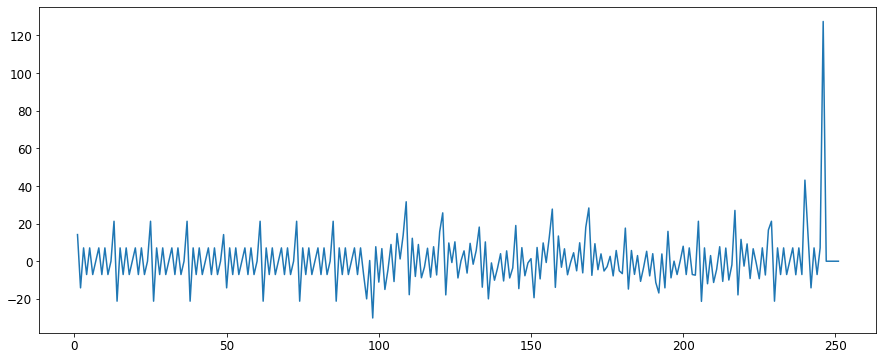

In [44]:
y1.plot(figsize=(15, 6))
plt.show()

In [45]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8


# decomposition = sm.tsa.seasonal_decompose(y, model='additive')
# fig = decomposition.plot()
# plt.show()

import statsmodels.api as sm

In [48]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2109      1.412     -0.149      0.881      -2.979       2.557
ma.L1          0.2767      1.413      0.196      0.845      -2.493       3.046
ar.S.L12       0.8152      0.091      8.942      0.000       0.637       0.994
sigma2       114.9986      1.944     59.154      0.000     111.188     118.809


In [54]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0779      0.065      1.204      0.229      -0.049       0.205
ar.S.L12       0.8206      0.090      9.080      0.000       0.643       0.998
sigma2       115.0512      1.920     59.923      0.000     111.288     118.814


In [66]:
x = pd_0['Monthly Depth']
pd_0.columns

Index(['Year_Month', 'Monthly Depth'], dtype='object')

In [ ]:
#ARIMAX:
x = 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

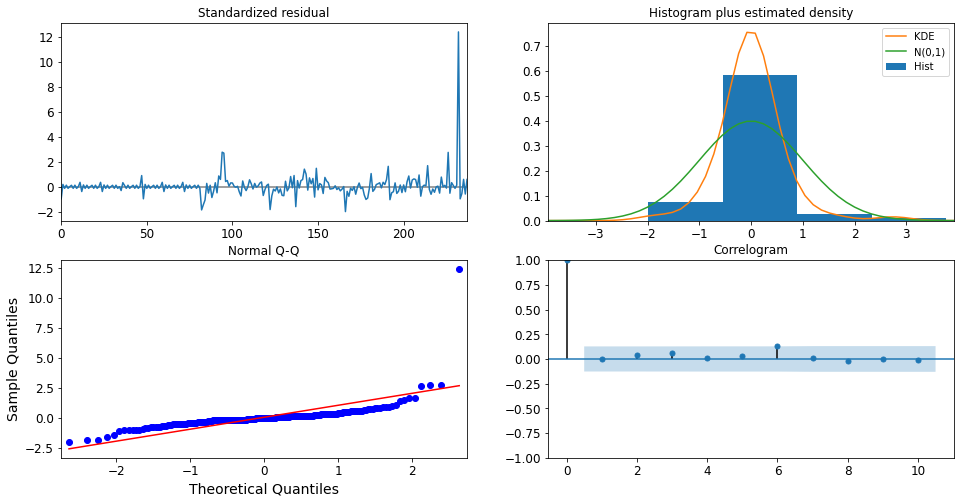

In [55]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [61]:
pred = results.get_prediction(ds=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred

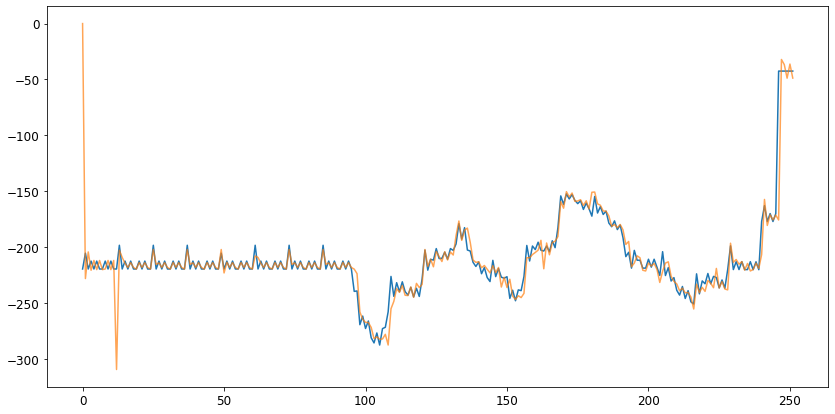

In [57]:
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))


In [45]:
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


In [46]:
pd_0.head()

,Year_Month,Monthly Depth
0,2000-01-01,-219.456097
1,2000-02-01,-205.297639
2,2000-03-01,-219.456097
3,2000-04-01,-212.376868
4,2000-05-01,-219.456097


In [48]:
y_forecasted = pred.predicted_mean
# y_truth = y['2016-01-01':]

pd_0_truth = pd_0.loc[pd_0['Year_Month'] >= '2016-01-01']

# y_truth = pd_0['2016-01-01 00:00:00':]
# date_mask = (pd_0.ds >= '2016-01-01 00:00:00')


# mse = ((y_forecasted - y_truth) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [22]:
### Check ACF BEFORE FITTING THE MODEL;

### Same as residuals

### Vector (Multivariate) Time Series ARIMA 


In [51]:
y_truth = pd_0_truth['Monthly Depth']

In [52]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 236.45


In [53]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 15.38


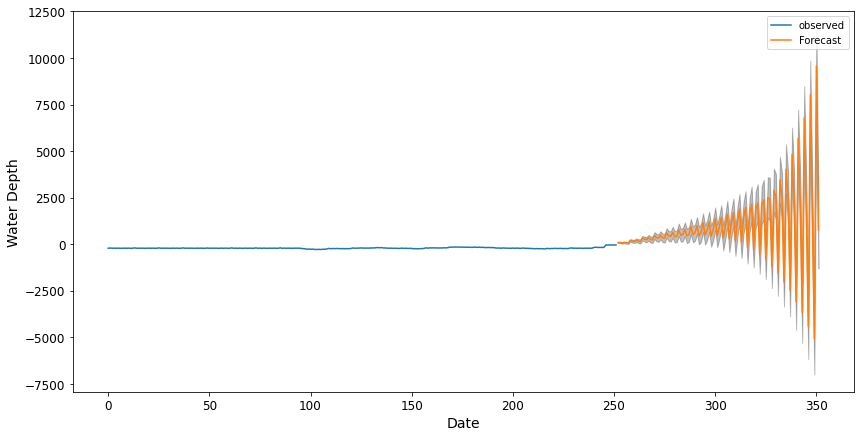

In [54]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Water Depth')
plt.legend()
plt.show()